In [1]:
import numpy as np
from numba import njit, uint64, float64
from numba.typed import Dict
from hftbacktest import BUY, SELL, GTX, LIMIT, BUY_EVENT
from hftbacktest import BacktestAsset, ROIVectorMarketDepthBacktest, Recorder
from hftbacktest.stats import LinearAssetRecord
from matplotlib import pyplot as plt
from scipy import stats

# beerusdt = np.load('hft_db/beerusdt_20240601.npz')['data']
# beerusdt_latency = 'latency/beerusdt_20240601.npz'
binance = np.load('hft_db/binance_20240601.npz')['data']
binance_latency = 'latency/binance_20240601.npz'
# btcusd_multiday = ['hft_db/btcusdt_20240801.npz', 'hft_db/btcusdt_20240802.npz', 'hft_db/btcusdt_20240803.npz']
# btcusd = np.load('hft_db/btcusdt_20240804.npz')['data']
# btcusd_latency = 'latency/btcusdt_20240804.npz'



In [2]:
asset_binance = (
    BacktestAsset()
    # .data(btcusd)
    # .intp_order_latency(btcusd_latency)
    .data(binance)
    .intp_order_latency(binance_latency)
    .linear_asset(1.0)
    # .constant_latency(10_000_000, 10_000_000)
    .power_prob_queue_model(2.0)
    .no_partial_fill_exchange()
    # .trading_value_fee_model(-0.00005, 0.00015)
    .trading_value_fee_model(-0.00002, 0.00023)
    # .trading_value_fee_model(0.00011, 0.00023)
    .tick_size(0.1)
    .lot_size(0.001)
    .last_trades_capacity(10000)
    # .roi_lb(55000)
    # .roi_ub(69500)
    .roi_lb(67000)
    .roi_ub(68500)
)

# asset_beer = (
#     BacktestAsset()
#         .data(beerusdt)
#         .intp_order_latency(beerusdt_latency)
#         .linear_asset(1.0)
#         # .constant_latency(10_000_000, 10_000_000)
#         .risk_adverse_queue_model()
#         .no_partial_fill_exchange()
#         .trading_value_fee_model(-0.00005, 0.00015)
#         .tick_size(0.00001)
#         .lot_size(1)
#         .last_trades_capacity(2)
#         .roi_lb(0.15)
#         .roi_ub(0.19)
# )

# asset_binance = (
#     BacktestAsset()
#     .data([
#         "hft_db/btcusdt_20240802.npz",
#         "hft_db/btcusdt_20240803.npz",
#         "hft_db/btcusdt_20240804.npz"
#     ])
#     .intp_order_latency(
#         [
#             "latency/btcusdt_20240802.npz",
#             "latency/btcusdt_20240803.npz",
#             "latency/btcusdt_20240804.npz",
#         ]
#     )
#     .linear_asset(1.0)
#     # .constant_latency(10_000_000, 10_000_000)
#     .power_prob_queue_model(2.0)
#     .no_partial_fill_exchange()
#     # .trading_value_fee_model(-0.00005, 0.00015)
#     .trading_value_fee_model(-0.00006, 0.00023)
#     # .trading_value_fee_model(0.00011, 0.00023)
#     .tick_size(0.001)
#     .lot_size(0.1)
#     .last_trades_capacity(10000)
#     .roi_lb(55000)
#     .roi_ub(66500)
# )

In [3]:
@njit
def measure_trading_intensity_and_volatility(hbt):
    tick_size = hbt.depth(0).tick_size
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan

    # Checks every 100 milliseconds.
    while hbt.elapse(100_000_000) == 0:
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            # print(f'Last trades: {len(hbt.last_trades(0))}')
            for last_trade in hbt.last_trades(0):
                trade_price_tick = last_trade.px / tick_size

                if last_trade.ev & BUY_EVENT == BUY_EVENT:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth

        hbt.clear_last_trades(0)

        depth = hbt.depth(0)

        best_bid_tick = depth.best_bid_tick
        best_ask_tick = depth.best_ask_tick

        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (best_bid_tick + best_ask_tick) / 2.0
        # print(f'Best bid: {best_bid_tick}, Best ask: {best_ask_tick}, Mid price: {mid_price_tick}')
        if mid_price_tick - prev_mid_price_tick > 10000 or mid_price_tick - prev_mid_price_tick < -10000:
            print('Large price change detected...')
            print(f'Best bid: {best_bid_tick}, Best ask: {best_ask_tick}')
            print(mid_price_tick)
            print(prev_mid_price_tick)
            print('Skipping iteration...')
            continue

        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        # print(mid_price_tick, best_ask_tick, best_bid_tick)

        t += 1
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
    return arrival_depth[:t], mid_price_chg[:t]

hbt = ROIVectorMarketDepthBacktest([asset_binance])
arrival_depth, mid_price_chg = measure_trading_intensity_and_volatility(hbt)
hbt.close()
print(f'arrival_depth: {arrival_depth}, Len: {len(arrival_depth)}')
print(f'mid_price_chg: {mid_price_chg}, Len: {len(mid_price_chg)}')

Large price change detected...
Best bid: 675470, Best ask: 675479
675474.5
-0.5
Skipping iteration...
arrival_depth: [ nan -inf -inf ...  0.1 -inf -inf], Len: 863999
mid_price_chg: [nan  0.  0. ...  0.  0.  0.], Len: 863999


In [4]:
max(mid_price_chg[1:])

np.float64(587.0)

In [5]:
@njit
def measure_trading_intensity(order_arrival_depth, out):
    max_tick = 0
    for depth in order_arrival_depth:
        if not np.isfinite(depth):
            continue

        # Sets the tick index to 0 for the nearest possible best price
        # as the order arrival depth in ticks is measured from the mid-price
        tick = round(depth / .5) - 1

        # In a fast-moving market, buy trades can occur below the mid-price (and vice versa for sell trades)
        # since the mid-price is measured in a previous time-step;
        # however, to simplify the problem, we will exclude those cases.
        if tick < 0 or tick >= len(out):
            continue

        # All of our possible quotes within the order arrival depth,
        # excluding those at the same price, are considered executed.
        out[:tick] += 1

        max_tick = max(max_tick, tick)
    return out[:max_tick]

tmp = np.zeros(500, np.float64)

lambda_bin = measure_trading_intensity(arrival_depth[:6000], tmp)
lambda_bin /= 600
ticks_bin = np.arange(len(lambda_bin)) + 0.5
print(f'lambda_: {lambda_bin}, Len: {len(lambda_bin)}')

lambda_: [1.47333333 1.055      0.905      0.72666667 0.68333333 0.54333333
 0.41666667 0.32       0.31       0.30333333 0.29666667 0.28166667
 0.27666667 0.26833333 0.255      0.25166667 0.24166667 0.23166667
 0.23       0.22333333 0.215      0.21       0.20666667 0.20166667
 0.19833333 0.19333333 0.19166667 0.18333333 0.17833333 0.17
 0.16333333 0.16333333 0.16       0.15666667 0.15166667 0.14666667
 0.145      0.145      0.14166667 0.14166667 0.13666667 0.13666667
 0.13666667 0.13333333 0.13166667 0.13166667 0.12833333 0.12833333
 0.125      0.125      0.11666667 0.11166667 0.11       0.10666667
 0.10666667 0.10666667 0.10666667 0.105      0.105      0.10333333
 0.10333333 0.10166667 0.09833333 0.09833333 0.09833333 0.09333333
 0.09       0.08833333 0.085      0.08333333 0.08166667 0.08
 0.07833333 0.07833333 0.07833333 0.07666667 0.075      0.075
 0.075      0.075      0.07166667 0.06833333 0.06833333 0.06833333
 0.06833333 0.06833333 0.06666667 0.06666667 0.06666667 0.06333333
 0.

In [6]:
# plt.plot(ticks_beer, lambda_beer)
# plt.xlabel('$ \delta $ (ticks from the mid-price)')
# plt.ylabel('Count (per second)')

<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
C:\Users\adity\AppData\Local\Temp\ipykernel_20016\2167234442.py:19: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('$ \delta $ (ticks from the mid-price)')


A: 0.1686207626983379, k: 0.01091144534450776


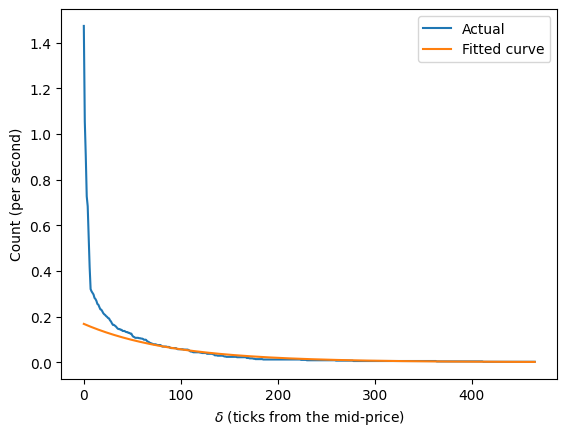

In [7]:
@njit
def linear_regression(x, y):
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = (w * sxy - sx * sy) / (w * sx2 - sx**2)
    intercept = (sy - slope * sx) / w
    return slope, intercept
y = np.log(lambda_bin)
k_, logA = linear_regression(ticks_bin, y)
A = np.exp(logA)
k = -k_

print(f'A: {A}, k: {k}')
plt.plot(lambda_bin)
plt.plot(A * np.exp(-k * ticks_bin))
plt.xlabel('$ \delta $ (ticks from the mid-price)')
plt.ylabel('Count (per second)')
plt.legend(['Actual', 'Fitted curve'])

A: 0.4008449181318196, k: 0.021967370982788503


<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
C:\Users\adity\AppData\Local\Temp\ipykernel_20016\263886902.py:12: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('$ \delta $ (ticks from the mid-price)')


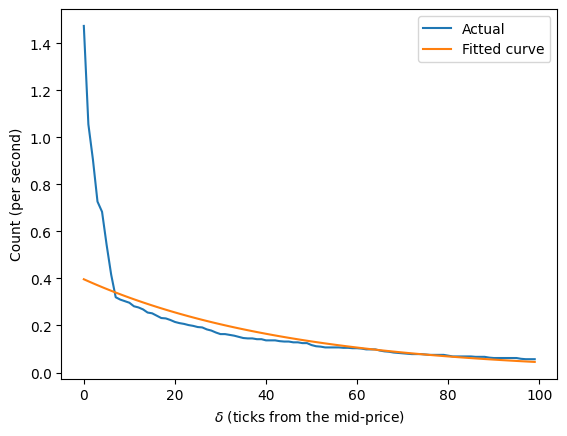

In [8]:
x_shallow = ticks_bin[:100]
lambda_shallow = lambda_bin[:100]

y = np.log(lambda_shallow)
k_, logA = linear_regression(x_shallow, y)
A = np.exp(logA)
k = -k_

print(f'A: {A}, k: {k}')
plt.plot(lambda_shallow)
plt.plot(A * np.exp(-k * x_shallow))
plt.xlabel('$ \delta $ (ticks from the mid-price)')
plt.ylabel('Count (per second)')
plt.legend(['Actual', 'Fitted curve'])

In [9]:
volatility = np.nanstd(mid_price_chg) * np.sqrt(10)
print(volatility)

13.531374955915547


In [10]:
@njit
def compute_coeff(xi, gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = 1 / (xi * delta) * np.log(1 + xi * delta * inv_k)
    c2 = np.sqrt(np.divide(gamma, 2 * A * delta * k) * ((1 + xi * delta * inv_k) ** (k / (xi * delta) + 1)))
    return c1, c2

gamma = 0.05
delta = 1
volatility = 14.66
c1, c2 = compute_coeff(gamma, gamma, delta, A, k)

half_spread_tick = 1 * c1 + 1 / 2 * c2 * volatility
skew = c2 * volatility
print('half_spread_tick={}, skew={}'.format(half_spread_tick, skew))
pct = stats.percentileofscore(arrival_depth[np.isfinite(arrival_depth)], half_spread_tick)
your_pct = 100 - pct
print('{:.2f}%'.format(your_pct))

half_spread_tick=52.745650837835754, skew=58.02511686654137
0.56%


In [11]:
from numba.typed import Dict
from hftbacktest import BUY, SELL, GTX, LIMIT

out_dtype = np.dtype([
    ('half_spread_tick', 'f8'),
    ('skew', 'f8'),
    ('volatility', 'f8'),
    ('A', 'f8'),
    ('k', 'f8')
])

@njit
def glft_market_maker(hbt, recorder):
    tick_size = hbt.depth(0).tick_size
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)
    out = np.zeros(10_000_000, out_dtype)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan

    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + 0.5

    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.05
    delta = 1

    order_qty = 1
    max_position = 20

    # Checks every 100 milliseconds.
    while hbt.elapse(100_000_000) == 0:
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for last_trade in hbt.last_trades(0):
                trade_price_tick = last_trade.px / tick_size

                if last_trade.ev & BUY_EVENT == BUY_EVENT:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth

        hbt.clear_last_trades(0)
        hbt.clear_inactive_orders(0)

        depth = hbt.depth(0)
        position = hbt.position(0)
        orders = hbt.orders(0)

        best_bid_tick = depth.best_bid_tick
        best_ask_tick = depth.best_ask_tick

        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (best_bid_tick + best_ask_tick) / 2.0

        if mid_price_tick - prev_mid_price_tick > 10000 or mid_price_tick - prev_mid_price_tick < -10000:
            print('Large price change detected, skipping iter...')
            continue

        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick

        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.

        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                if len(lambda_) > 2:
                    lambda_ = lambda_[:70] / 600
                    x = ticks[:len(lambda_)]
                    y = np.log(lambda_)
                    k_, logA = linear_regression(x, y)
                    A = np.exp(logA)
                    k = -k_

                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)

        #--------------------------------------------------------
        # Computes bid price and ask price.

        c1, c2 = compute_coeff(gamma, gamma, delta, A, k)

        half_spread_tick = c1 + delta / 2 * c2 * volatility
        skew = c2 * volatility

        reservation_price_tick = mid_price_tick - skew * position

        bid_price_tick = np.minimum(np.round(reservation_price_tick - half_spread_tick), best_bid_tick)
        ask_price_tick = np.maximum(np.round(reservation_price_tick + half_spread_tick), best_ask_tick)

        bid_price = bid_price_tick * tick_size
        ask_price = ask_price_tick * tick_size

        #--------------------------------------------------------
        # Updates quotes.

        # Cancel orders if they differ from the updated bid and ask prices.
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.price != bid_price)
                    or (order.side == SELL and order.price != ask_price)
                ):
                    hbt.cancel(0, order.order_id, False)

        # If the current position is within the maximum position,
        # submit the new order only if no order exists at the same price.
        if position < max_position and np.isfinite(bid_price):
            bid_price_as_order_id = round(bid_price / tick_size)
            if bid_price_as_order_id not in orders:
                hbt.submit_buy_order(0, bid_price_as_order_id, bid_price, order_qty, GTX, LIMIT, False)
        if position > -max_position and np.isfinite(ask_price):
            ask_price_as_order_id = round(ask_price / tick_size)
            if ask_price_as_order_id not in orders:
                hbt.submit_sell_order(0, ask_price_as_order_id, ask_price, order_qty, GTX, LIMIT, False)

        #--------------------------------------------------------
        # Records variables and stats for analysis.

        out[t].half_spread_tick = half_spread_tick
        out[t].skew = skew
        out[t].volatility = volatility
        out[t].A = A
        out[t].k = k

        t += 1

        if t >= len(arrival_depth) or t >= len(mid_price_chg) or t >= len(out):
            raise Exception

        # Records the current state for stat calculation.
        recorder.record(hbt)
    return out[:t]


hbt = ROIVectorMarketDepthBacktest([asset_binance])

recorder = Recorder(1, 5_000_000)

out = glft_market_maker(hbt, recorder.recorder)

hbt.close()

stats = LinearAssetRecord(recorder.get(0)).stats(book_size=30_000)
stats.summary()

Large price change detected, skipping iter...


start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-06-01 00:00:00,2024-06-01 23:59:50,-138.674078,-139.053346,-0.108706,0.109025,2696.312073,6085.251402,-0.997067,-0.000018,270822.8


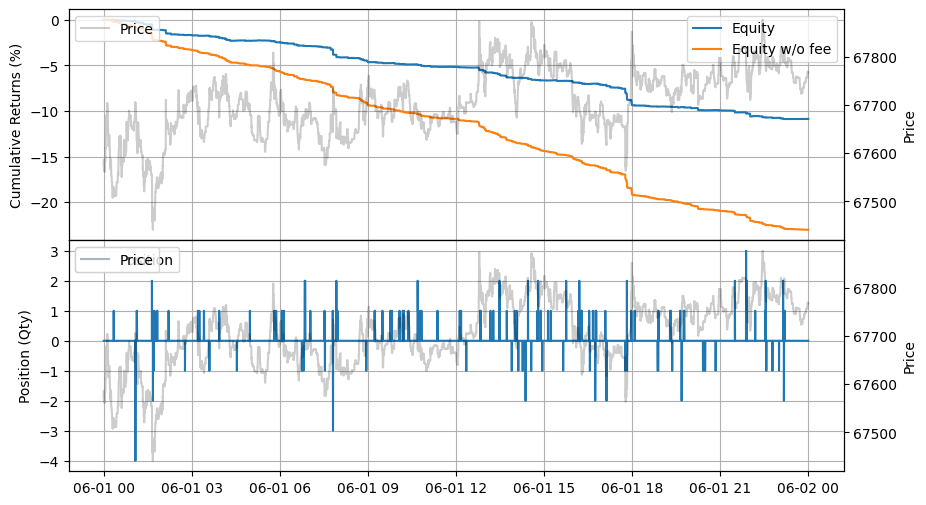

In [12]:
stats.plot()

In [13]:
from numba.typed import Dict

@njit
def glft_market_maker(hbt, recorder):
    tick_size = hbt.depth(0).tick_size
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)
    out = np.zeros(10_000_000, out_dtype)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan

    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + 0.5

    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.05
    delta = 1
    adj1 = 1
    adj2 = 0.05 # Uses the same value as gamma.

    order_qty = 1
    max_position = 20

    # Checks every 100 milliseconds.
    while hbt.elapse(100_000_000) == 0:
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for last_trade in hbt.last_trades(0):
                trade_price_tick = last_trade.px / tick_size

                if last_trade.ev & BUY_EVENT == BUY_EVENT:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth

        hbt.clear_last_trades(0)
        hbt.clear_inactive_orders(0)

        depth = hbt.depth(0)
        position = hbt.position(0)
        orders = hbt.orders(0)

        best_bid_tick = depth.best_bid_tick
        best_ask_tick = depth.best_ask_tick

        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (best_bid_tick + best_ask_tick) / 2.0

        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick

        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.

        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                if len(lambda_) > 2:
                    lambda_ = lambda_[:70] / 600
                    x = ticks[:len(lambda_)]
                    y = np.log(lambda_)
                    k_, logA = linear_regression(x, y)
                    A = np.exp(logA)
                    k = -k_

                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)

        #--------------------------------------------------------
        # Computes bid price and ask price.

        c1, c2 = compute_coeff(gamma, gamma, delta, A, k)

        half_spread_tick = (c1 + delta / 2 * c2 * volatility) * adj1
        skew = c2 * volatility * adj2

        reservation_price_tick = mid_price_tick - skew * position

        bid_price_tick = np.minimum(np.round(reservation_price_tick - half_spread_tick), best_bid_tick)
        ask_price_tick = np.maximum(np.round(reservation_price_tick + half_spread_tick), best_ask_tick)

        bid_price = bid_price_tick * tick_size
        ask_price = ask_price_tick * tick_size

        #--------------------------------------------------------
        # Updates quotes.

        # Cancel orders if they differ from the updated bid and ask prices.
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.price_tick != bid_price_tick)
                    or (order.side == SELL and order.price_tick != ask_price_tick)
                ):
                    hbt.cancel(0, order.order_id, False)

        # If the current position is within the maximum position,
        # submit the new order only if no order exists at the same price.
        if position < max_position and np.isfinite(bid_price):
            bid_price_as_order_id = round(bid_price / tick_size)
            if bid_price_as_order_id not in orders:
                hbt.submit_buy_order(0, bid_price_as_order_id, bid_price, order_qty, GTX, LIMIT, False)
        if position > -max_position and np.isfinite(ask_price):
            ask_price_as_order_id = round(ask_price / tick_size)
            if ask_price_as_order_id not in orders:
                hbt.submit_sell_order(0, ask_price_as_order_id, ask_price, order_qty, GTX, LIMIT, False)

        #--------------------------------------------------------
        # Records variables and stats for analysis.

        out[t].half_spread_tick = half_spread_tick
        out[t].skew = skew
        out[t].volatility = volatility
        out[t].A = A
        out[t].k = k

        t += 1

        if t >= len(arrival_depth) or t >= len(mid_price_chg) or t >= len(out):
            raise Exception

        # Records the current state for stat calculation.
        recorder.record(hbt)
    return out[:t]

In [14]:
hbt = ROIVectorMarketDepthBacktest([asset_binance])

recorder = Recorder(1, 5_000_000)

out = glft_market_maker(hbt, recorder.recorder)

hbt.close()

stats = LinearAssetRecord(recorder.get(0)).stats(book_size=30_000)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-06-01 00:00:00,2024-06-01 23:59:50,-96.96028,-112.162358,-0.350011,0.35099,1782.206274,4022.256292,-0.99721,-0.000087,1.0181e6


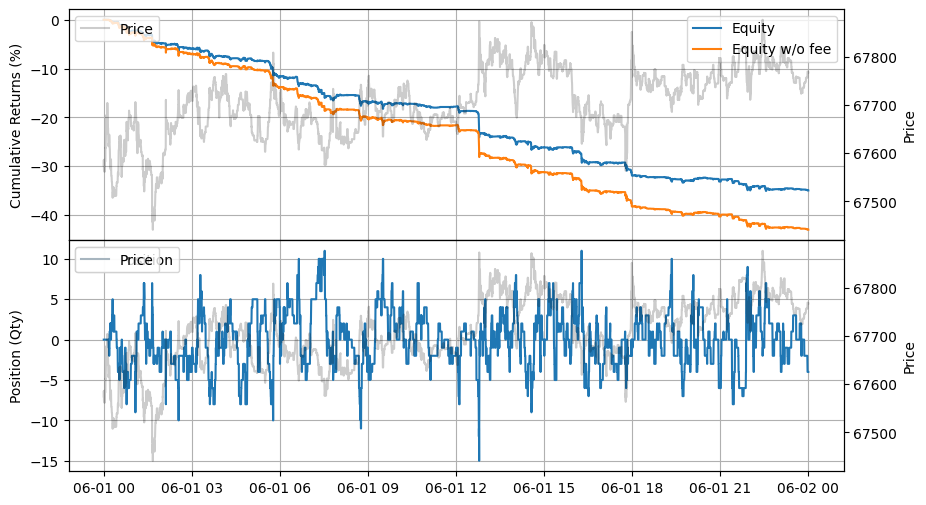

In [15]:
stats.plot()

Text(0, 0.5, 'Skew (tick)')

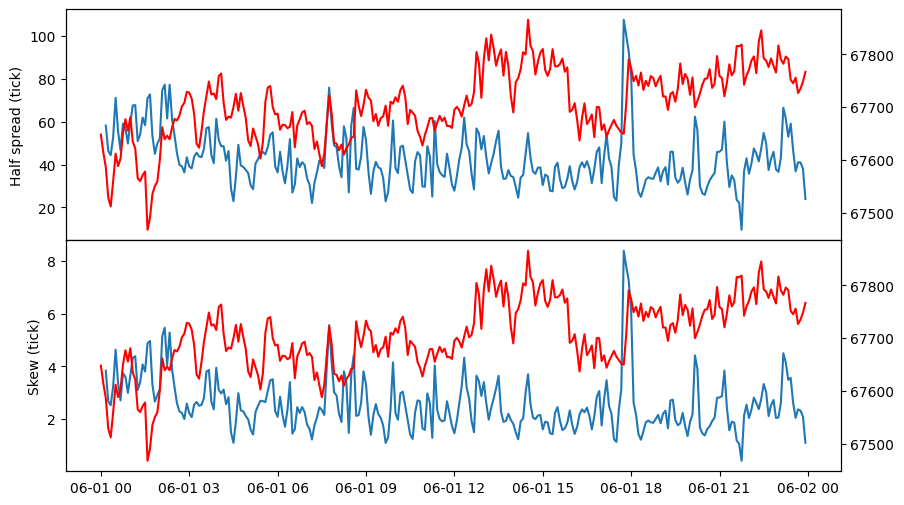

In [16]:
import polars as pl

records = recorder.get(0)
df = pl.DataFrame(out).with_columns(
    pl.Series('timestamp', records['timestamp']),
    pl.Series('price', records['price'])
).with_columns(
    pl.from_epoch('timestamp', time_unit='ns')
)

df = df.group_by_dynamic(
    'timestamp', every='5m'
).agg(
    pl.col('price').last(),
    pl.col('half_spread_tick').last(),
    pl.col('skew').last(),
    pl.col('volatility').last(),
    pl.col('A').last(),
    pl.col('k').last(),
)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(10, 6)

ax1.plot(df['timestamp'], df['half_spread_tick'])
ax1.twinx().plot(df['timestamp'], df['price'], 'r')
ax1.set_ylabel('Half spread (tick)')

ax2.plot(df['timestamp'], df['skew'])
ax2.twinx().plot(df['timestamp'], df['price'], 'r')
ax2.set_ylabel('Skew (tick)')

Text(0, 0.5, 'k ($ tick^{-1} $)')

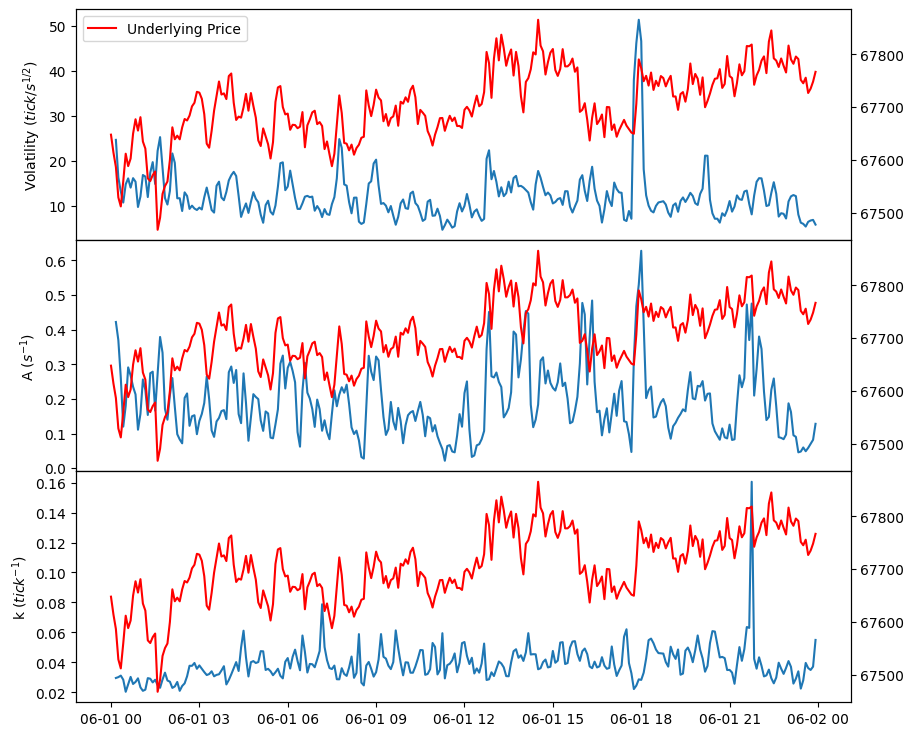

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(10, 9)

ax1.plot(df['timestamp'], df['volatility'])
ax1p = ax1.twinx()
ax1p.plot(df['timestamp'], df['price'], 'r', label = 'Underlying Price')
ax1p.legend(loc=0)
ax1.set_ylabel('Volatility ($ tick/s^{1/2} $)')

ax2.plot(df['timestamp'], df['A'])
ax2.twinx().plot(df['timestamp'], df['price'], 'r')
ax2.set_ylabel('A ($ s^{-1} $)')

ax3.plot(df['timestamp'], df['k'])
ax3.twinx().plot(df['timestamp'], df['price'], 'r')
ax3.set_ylabel('k ($ tick^{-1} $)')

In [18]:
from numba.typed import Dict
from numba import uint64

@njit
def gridtrading_glft_mm(hbt, recorder):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size

    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan

    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + 0.5

    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.05
    delta = 1
    adj1 = 1
    adj2 = 0.05

    order_qty = 1
    max_position = 20
    grid_num = 20

    # Checks every 100 milliseconds.
    while hbt.elapse(100_000_000) == 0:
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for last_trade in hbt.last_trades(asset_no):
                trade_price_tick = last_trade.px / tick_size

                if last_trade.ev & BUY_EVENT == BUY_EVENT:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth

        hbt.clear_last_trades(asset_no)
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid_tick = depth.best_bid_tick
        best_ask_tick = depth.best_ask_tick

        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (best_bid_tick + best_ask_tick) / 2.0

        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick

        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.

        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                if len(lambda_) > 2:
                    lambda_ = lambda_[:70] / 600
                    x = ticks[:len(lambda_)]
                    y = np.log(lambda_)
                    k_, logA = linear_regression(x, y)
                    A = np.exp(logA)
                    k = -k_

                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)

        #--------------------------------------------------------
        # Computes bid price and ask price.

        c1, c2 = compute_coeff(gamma, gamma, delta, A, k)

        half_spread_tick = (c1 + delta / 2 * c2 * volatility) * adj1
        skew = c2 * volatility * adj2

        reservation_price_tick = mid_price_tick - skew * position

        bid_price_tick = np.minimum(np.round(reservation_price_tick - half_spread_tick), best_bid_tick)
        ask_price_tick = np.maximum(np.round(reservation_price_tick + half_spread_tick), best_ask_tick)

        bid_price = bid_price_tick * tick_size
        ask_price = ask_price_tick * tick_size

        grid_interval = max(np.round(half_spread_tick) * tick_size, tick_size)

        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval

        #--------------------------------------------------------
        # Updates quotes.

        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)

                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price

                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)

                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval

        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)

        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)

        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)

        #--------------------------------------------------------
        # Records variables and stats for analysis.

        t += 1

        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception

        # Records the current state for stat calculation.
        recorder.record(hbt)
    return out[:t]

hbt = ROIVectorMarketDepthBacktest([asset_binance])

recorder = Recorder(1, 5_000_000)

out = gridtrading_glft_mm(hbt, recorder.recorder)

hbt.close()

stats = LinearAssetRecord(recorder.get(0)).stats(book_size=30_000)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-06-01 00:00:00,2024-06-01 23:59:50,0.234125,0.295815,0.00159,0.097372,1802.208589,4067.321135,0.016333,3.9105e-7,1490127.1


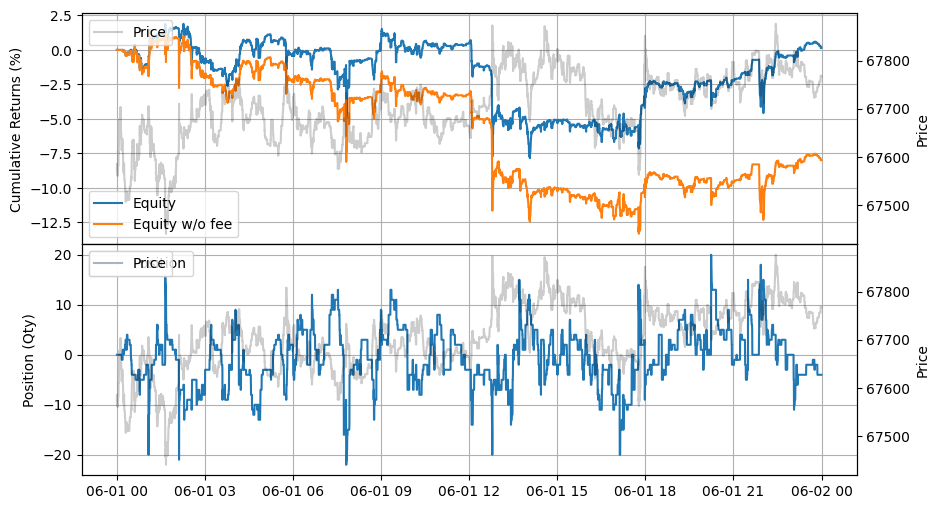

In [19]:
stats.plot()